In [5]:
import pandas as pd
import numpy as np

import seaborn as sns

import warnings
import yfinance as yf

from dynamic_portfolio.portfolio_backtest import Portfolio


%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

warnings.filterwarnings(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Loading sp500 csv
sp500 = yf.download("^GSPC", start="2021-01-01", end="2022-11-15")
units_sp500 = int(1_000_000/3700.649902	)

sp500['return'] = sp500['Adj Close'].pct_change().dropna()
#sp500['return'] = sp500['Adj Close']*units_sp500

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000,NaN
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000,0.007083
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000,0.005710
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000,0.014847
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4773040000,0.005492
...,...,...,...,...,...,...,...
2022-11-08,3817.020020,3859.399902,3786.280029,3828.110107,3828.110107,4607640000,0.005598
2022-11-09,3810.939941,3818.199951,3744.219971,3748.570068,3748.570068,4645010000,-0.020778
2022-11-10,3859.889893,3958.330078,3859.889893,3956.370117,3956.370117,5781260000,0.055434


In [7]:
final_results = Portfolio(1_000_000, 0, 0, 0.1).rotation_strategy(n_longs=8, n_shorts=2)

Day 1
Closed positions
 --------------------
Opened positions
 --------------------
buy 1898 WDC at price=52.66 capital=900051.3200000001, trades=1
buy 1177 MU at price=76.44 capital=810081.4400000001, trades=2
buy 3403 MOS at price=23.8 capital=729090.04, trades=3
buy 2030 NRG at price=35.9 capital=656213.04, trades=4
buy 125 NFLX at price=521.55 capital=591019.29, trades=5
buy 273 MOH at price=215.71 capital=532130.4600000001, trades=6
buy 2292 AES at price=23.21 capital=478933.1400000001, trades=7
buy 173 SBAC at price=275.67 capital=431242.2300000001, trades=8
sell 2422 OXY at price=17.8: capital=474353.8300000001, trades=9
sell 1140 UAL at price=41.58: capital=521755.0300000001, trades=10
Day 2
Closed positions
 --------------------
sell 1898 WDC at price=53.045 capital=622434.4400000001, trades=11
sell 1177 MU at price=76.36 capital=712310.16, trades=12
sell 3403 MOS at price=25.0 capital=797385.16, trades=13
sell 2030 NRG at price=37.26 capital=873022.9600000001, trades=14
sell 

Opened positions
 --------------------
buy 128 EQIX at price=866.79 capital=1000050.1014999988, trades=3127
buy 186 DXCM at price=536.12 capital=900331.7814999989, trades=3128
buy 1031 CSGP at price=87.26 capital=810366.7214999988, trades=3129
buy 691 RL at price=117.24 capital=729353.8814999989, trades=3130
buy 4215 CTRA at price=17.3 capital=656434.3814999989, trades=3131
buy 3320 EQT at price=19.77 capital=590797.9814999988, trades=3132
buy 1070 UDR at price=55.19 capital=531744.6814999988, trades=3133
buy 82 MSCI at price=646.39 capital=478740.7014999988, trades=3134
sell 430 ABBV at price=111.18: capital=526548.1014999988, trades=3135
sell 1802 DVN at price=29.21: capital=579184.5214999989, trades=3136
Day 170
Closed positions
 --------------------
sell 128 EQIX at price=865.5 capital=689968.5214999989, trades=3137
sell 186 DXCM at price=545.41 capital=791414.7814999989, trades=3138
sell 1031 CSGP at price=87.57 capital=881699.4514999989, trades=3139
sell 691 RL at price=114.88 ca

Opened positions
 --------------------
buy 406 EPAM at price=294.66 capital=1078440.8420000027, trades=5799
buy 6270 F at price=17.2 capital=970596.8420000027, trades=5800
buy 805 APTV at price=120.46 capital=873626.5420000027, trades=5801
buy 671 MHK at price=130.07 capital=786349.5720000027, trades=5802
buy 777 KMX at price=101.16 capital=707748.2520000028, trades=5803
buy 3897 AAL at price=18.16 capital=636978.7320000028, trades=5804
buy 177 MA at price=359.58 capital=573333.0720000027, trades=5805
buy 432 PPG at price=132.47 capital=516106.03200000274, trades=5806
sell 580 ADM at price=88.89: capital=567662.2320000028, trades=5807
Day 310
Closed positions
 --------------------
sell 1378 MOS at price=66.37 capital=659120.0920000027, trades=5808
sell 406 EPAM at price=297.37 capital=779852.3120000027, trades=5809
sell 6270 F at price=17.01 capital=886505.0120000027, trades=5810
sell 805 APTV at price=120.53 capital=983531.6620000027, trades=5811
sell 777 KMX at price=97.29 capital=10

Closed positions
 --------------------
sell 1403 RCL at price=50.71 capital=666522.8900000033, trades=8083
sell 207 HUM at price=509.75 capital=772041.1400000033, trades=8084
sell 1439 WYNN at price=67.5 capital=869173.6400000033, trades=8085
sell 3663 PARA at price=22.86 capital=952909.8200000033, trades=8086
sell 1769 LVS at price=40.33 capital=1024253.5900000033, trades=8087
sell 473 ALL at price=131.45 capital=1086429.4400000034, trades=8088
sell 5131 CCL at price=10.88 capital=1142254.7200000035, trades=8089
buy 166 ADBE at price=292.82 capital=1093646.6000000034, trades=8090
buy 192 ALB at price=293.39 capital=1037315.7200000033, trades=8091
Opened positions
 --------------------
buy 1872 IRM at price=55.41 capital=933588.2000000033, trades=8092
buy 656 DLTR at price=142.3 capital=840239.4000000033, trades=8093
buy 1927 NEM at price=43.59 capital=756241.4700000032, trades=8094
buy 982 LEN at price=76.99 capital=680637.2900000033, trades=8095
buy 515 NVDA at price=132.145 capital=

In [21]:
final_df_portfolio = normalize(pd.DataFrame(final_results))*100
final_df_portfolio.set_index(final_df_sp.index, drop=True, inplace=True)
final_df_portfolio.rename(columns={0:'Portfolio'}, inplace=True)

In [20]:
final_df_sp = normalize(sp500)*100
final_df_sp = final_df_sp[['Adj Close']]

final_df_sp.rename(columns={'Adj Close':'SP500'}, inplace=True)

In [32]:
final_df_sp

,SP500
Date,
2021-01-04,100.000000
2021-01-05,100.708260
2021-01-06,101.283288
2021-01-07,102.787082
2021-01-08,103.351574
...,...
2022-11-08,103.444265
2022-11-09,101.294912
2022-11-10,106.910143


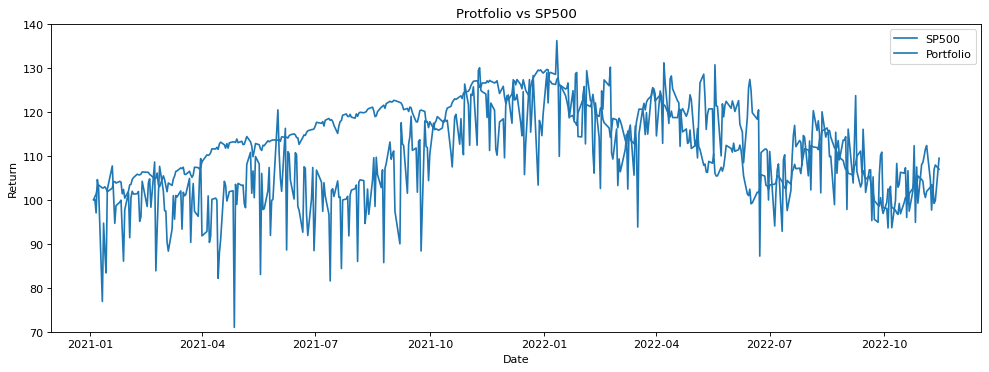

In [38]:
from matplotlib.pyplot import figure

figure(figsize=(15, 5), dpi=80)
plt.title('Protfolio vs SP500')
plt.ylabel('Return')
plt.ylim(70,140)
sns.lineplot(final_df_sp)
sns.lineplot(final_df_portfolio);

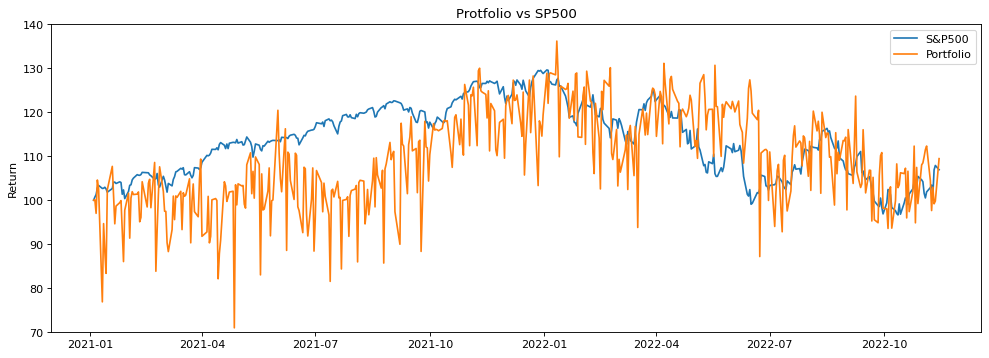

In [45]:
from matplotlib.pyplot import figure

figure(figsize=(15, 5), dpi=80)

plt.title('Protfolio vs SP500')
plt.ylabel('Return')
plt.ylim(70,140)
plt.plot(final_df_sp.index,final_df_sp, label = 'S&P500' )
plt.plot(final_df_sp.index,final_df_portfolio,  label = 'Portfolio' )
plt.legend();

ValueError: Data must be 1-dimensional

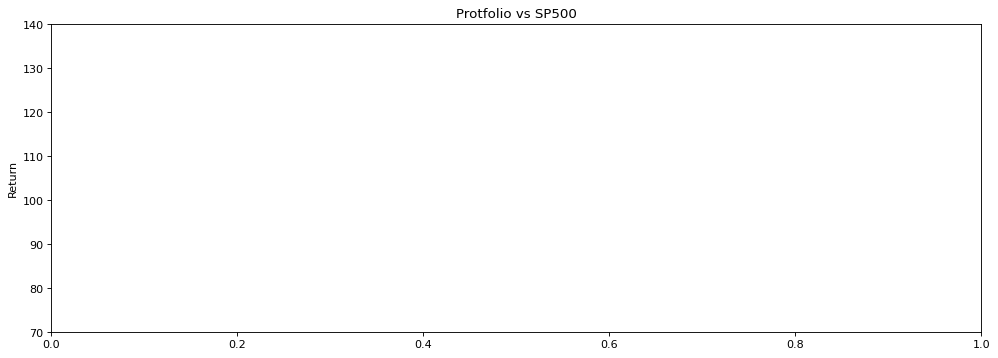

In [30]:
import matplotlib.pyplot as plt

figure(figsize=(15, 5), dpi=80)
plt.title('Protfolio vs SP500')
plt.ylabel('Return')
plt.ylim(70,140)
sns.lineplot(x =final_df_sp.index, y=final_df_sp)
sns.lineplot(x =final_df_sp.index, y=final_df_portfolio)
plt.legend()
plt.show();

In [9]:
def normalize (df):
  x=df.copy()
  for i in df.columns[:]:
    x[i]=x[i]/x[i][0]
  return x

In [ ]:
def interactive_plot(df,Title):
  fig=px.line(title=Title)
  for i in df.columns[1:]:
    fig.add_scatter(x=df['Date'],y=df[i], name=i)
  fig.show()